In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os


In [ ]:
!pip install selenium

     |████████████████████████████████| 958 kB 12.3 MB/s 
     |████████████████████████████████| 356 kB 16.9 MB/s 
     |████████████████████████████████| 138 kB 49.7 MB/s 
     |████████████████████████████████| 3.6 MB 38.9 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir "/content/drive/My Drive/"

mkdir: cannot create directory ‘/content/drive/My Drive/’: File exists


In [ ]:
!unzip "/content/drive/My Drive/DATASET.zip" -d "/content/drive/My Drive"

Archive:  /content/drive/My Drive/DATASET.zip
replace /content/drive/My Drive/DATASET/archive/test/0/449.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/My Drive/DATASET/archive/test/0/449.jpeg  
 extracting: /content/drive/My Drive/DATASET/archive/test/0/450.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/451.jpeg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/452.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/453.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/454.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/455.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/456.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/457.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/458.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/459.jpg  
  inflating: /content/drive/My Drive/DATASET/archive/test/0/460.jpg  
  infla

In [ ]:
!unzip "/content/drive/My Drive/object_detection/images.zip" -d "/content/drive/My Drive/object_detection/"

unzip:  cannot find or open /content/drive/My Drive/object_detection/images.zip, /content/drive/My Drive/object_detection/images.zip.zip or /content/drive/My Drive/object_detection/images.zip.ZIP.


In [ ]:
!unzip "/content/drive/My Drive/object_detection/annotations.zip" -d "/content/drive/My Drive/object_detection/"

unzip:  cannot find or open /content/drive/My Drive/object_detection/annotations.zip, /content/drive/My Drive/object_detection/annotations.zip.zip or /content/drive/My Drive/object_detection/annotations.zip.ZIP.


In [ ]:
def prep(data_folder_path):
    dirs = os.listdir(data_folder_path)
    
    images = []
    labels = []
  
    for dir_name in dirs:
        print(dir_name)
  
            
        if dir_name=='0':

          label = 0
          
        elif dir_name=='1':
          label= 1
        
        
        subject_dir_path = data_folder_path + "/" + dir_name
        
        
        subject_images_names = os.listdir(subject_dir_path)
      
        for image_name in subject_images_names:
           
            if image_name.startswith("."):
                continue;
            
           
            image_path = subject_dir_path + "/" + image_name
            

            
            
           
            images.append( image_path)            
            labels.append(label)
            
            
            
    return images,labels

In [ ]:
path = "/content/drive/My Drive/DATASET/archive/Train"
train_img , train_lab = prep(path)

1
0


In [ ]:
path = "/content/drive/My Drive/DATASET/archive/test"
test_img , test_lab = prep(path)

0
1


In [ ]:
tl = len(train_img)
train_data = []
c=0
for path in train_img:
  img = load_img(path,target_size=(224,224))
  img = img_to_array(img)
  img = preprocess_input(img)
  train_data.append(img)
  c+=1
  print(c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
tl = len(test_img)
test_data = []
c=0
for path in test_img:
  img = load_img(path,target_size=(224,224))
  img = img_to_array(img)
  img = preprocess_input(img)
  test_data.append(img)
  c+=1
  print(c)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [ ]:
trainY ,testY = np.array(train_data) , np.array(test_data)
trainX , testX = np.array(train_lab) , np.array(test_lab)

In [ ]:
trainY.shape


(536, 224, 224, 3)

In [ ]:
import pickle
with open("fire.pickle","wb") as f:
  pickle.dump([trainY,trainX,testY,testX],f)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
INIT_LR = 1e-4
EPOCHS = 100
BS = 64

opt = Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from tensorflow import keras
class callbacks(keras.callbacks.Callback):
  def on_epoch_end(self,epochs,logs={}):
    if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.86:
      print("\n Accuracy reached \n")
      self.model.stop_training = True
callbacks = callbacks()

In [ ]:
H = model.fit(
    aug.flow(trainY,trainX),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testY,testX),
    validation_steps=len(testX)//BS,epochs=EPOCHS,shuffle=True,callbacks = [callbacks])

Epoch 1/100
8/8 [==============================] - 19s 896ms/step - loss: 0.8232 - accuracy: 0.6048 - val_loss: 0.5900 - val_accuracy: 0.8174
Epoch 2/100
8/8 [==============================] - 4s 471ms/step - loss: 0.5426 - accuracy: 0.8226 - val_loss: 0.5335 - val_accuracy: 0.8087
Epoch 3/100
8/8 [==============================] - 3s 433ms/step - loss: 0.5371 - accuracy: 0.8203 - val_loss: 0.4268 - val_accuracy: 0.8261
Epoch 4/100
8/8 [==============================] - 3s 419ms/step - loss: 0.3472 - accuracy: 0.8589 - val_loss: 0.3515 - val_accuracy: 0.8435
Epoch 5/100
8/8 [==============================] - 3s 428ms/step - loss: 0.4149 - accuracy: 0.8438 - val_loss: 0.3020 - val_accuracy: 0.8870
Epoch 6/100
8/8 [==============================] - 4s 442ms/step - loss: 0.3006 - accuracy: 0.8945 - val_loss: 0.2700 - val_accuracy: 0.9130
Epoch 7/100
8/8 [==============================] - 3s 434ms/step - loss: 0.3046 - accuracy: 0.8711 - val_loss: 0.2450 - val_accuracy: 0.9130
Epoch 8/100


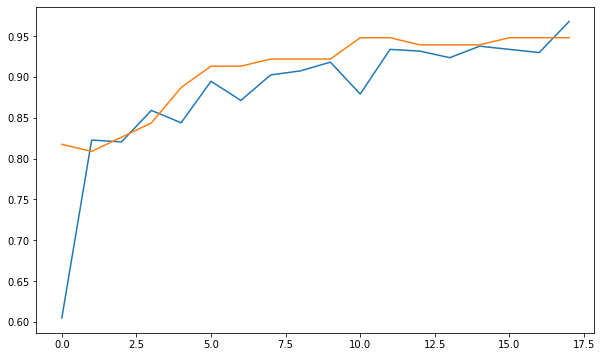

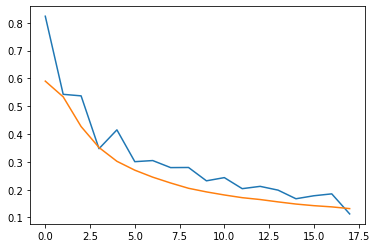

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(10,6))
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.figure()
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)

In [ ]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model_garbage_arch.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_garbage_weights.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
from tensorflow.keras.models import model_from_json
json_file = open('/content/drive/My Drive/DATASET/archive/model_fire_arch.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("/content/drive/My Drive/DATASET/archive/model_fire_weights.h5")

96.81
fire


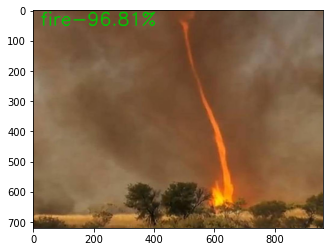

In [ ]:
import cv2
import time
clas = ["no fire","fire"]

path = "/content/drive/My Drive/DATASET/archive/test/1/100.jpg"
#path = "/content/drive/My Drive/DATASET/archive/test/0/450.jpg"
#path = "/content/drive/My Drive/DATASET/archive/test/0/450.jpg"

img = load_img(path,target_size=(224,224))
img1=cv2.imread(path)
img1 =cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
#re = cv2.imread(path)
#img =cv2.cvtColor(re,cv2.COLOR_BGR2RGB)
#img = cv2.resize(img,(224,224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img,axis=0)
last = time.time()
pred = model.predict(img)
#print(time.time()-last)
op=clas[np.argmax(pred)]
e = np.argmax(pred)
x = round(pred[0][e]*100,2)
conf = str(x)+'%'
print(x)
print(op)

op = op + '-' + conf
if x>80.0:
    cv2.putText(img1,op,(25,50),cv2.FONT_HERSHEY_SIMPLEX,2,(0,200,0),3)
plt.imshow(img1)


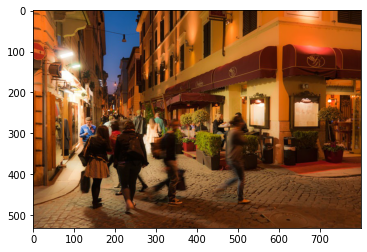

In [ ]:
path="/content/drive/My Drive/DATASET/archive/test/0/451.jpeg"
img=plt.imread(path)
plt.imshow(img)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
import cv2
from selenium import webdriver

fire_cas = cv2.CascadeClassifier("C:\\Users\\samra\\Desktop\\fire_detection.xml")
cap=cv2.VideoCapture(0)
while True:
    ret,fimg=cap.read()
    flag = 0
    # fimg = cv2.cvtColor(fimg,cv2.COLOR_BGR2RGB)
# fimg = cv2.imread("E:\\Datasets\\fire2.jfif")
    gray = cv2.cvtColor(fimg, cv2.COLOR_BGR2GRAY)
    fires = fire_cas.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in fires:
        flag=1
        cv2.rectangle(fimg,(x,y),(x+w,y+h),(255,0,0),2)
        img = fimg[y:y+h, x:x+w]
    cv2.imshow("win",fimg)
    k = cv2.waitKey(1)
    if k==ord('r'):
        break
    if flag==1:
        driver = webdriver.Chrome()
        driver.get('http://web.whatsapp.com')
        msg = "FIRE DETECTED PLEASE HELP..."
        # name = input('Enter the name of user or group : ')
        # print(type(name))
        name = 'Fire'
        input("Enter after screen load")
        user = driver.find_element_by_xpath('//span[@title = "{}"]'.format(name))
        user.click()
        msg_box = driver.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[2]/div/div[2]')
        msg_box.send_keys(msg)
        driver.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[3]/button/span').click()
        flag=0

# cap.release()
cv2.destroyAllWindows()

error: ignored

<IPython.core.display.Javascript object>

71.14
fire


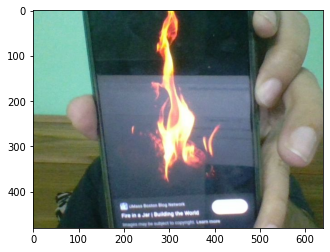

In [ ]:
filename=take_photo()
import cv2
import time
clas = ["no fire","fire"]

path =filename

img = load_img(path,target_size=(224,224))
img1=cv2.imread(path)
img1 =cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
#re = cv2.imread(path)
#img =cv2.cvtColor(re,cv2.COLOR_BGR2RGB)
#img = cv2.resize(img,(224,224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img,axis=0)
last = time.time()
pred = model.predict(img)
#print(time.time()-last)
op=clas[np.argmax(pred)]
e = np.argmax(pred)
x = round(pred[0][e]*100,2)
conf = str(x)+'%'
print(x)
print(op)

op = op + '-' + conf
if x>80.0:
    cv2.putText(img1,op,(25,50),cv2.FONT_HERSHEY_SIMPLEX,2,(0,200,0),3)
plt.imshow(img1)
# if e==1:
#         driver = webdriver.Chrome('/content/drive/My Drive/selenium/chromedriver.exe')
#         driver.get('http://web.whatsapp.com')
#         msg = "FIRE DETECTED PLEASE HELP..."
#         # name = input('Enter the name of user or group : ')
#         # print(type(name))
#         name = 'Fire'
#         input("Enter after screen load")
#         user = driver.find_element_by_xpath('//span[@title = "{}"]'.format(name))
#         user.click()
#         msg_box = driver.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[2]/div/div[2]')
#         msg_box.send_keys(msg)
#         driver.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[3]/button/span').click()
  




In [ ]:
# !pip install kora -q
# from kora.selenium import wd
# wd.get('http://web.whatsapp.com')
# msg = "FIRE DETECTED PLEASE HELP..."
# name = input('Enter the name of user or group : ')
# print(type(name))
# name = 'Fire'
# input("Enter after screen load")
# user = wd.find_element_by_xpath('//span[@title = "{}"]'.format(name))
# user.click()
# msg_box = wd.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[2]/div/div[2]')
# msg_box.send_keys(msg)
# wd.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[3]/button/span').click()


In [ ]:
!pip install selenium
import selenium

     |████████████████████████████████| 954 kB 4.1 MB/s 
     |████████████████████████████████| 138 kB 51.1 MB/s 
     |████████████████████████████████| 356 kB 41.2 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 3.5 MB 34.8 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
driver = webdriver.Chrome('/content/drive/My Drive/chromedriver.exe')
driver.get('http://web.whatsapp.com')
msg = "FIRE DETECTED PLEASE HELP..."
name = input('Enter the name of user or group : ')
print(type(name))
name = 'Fire'
input("Enter after screen load")
user = driver.find_element_by_xpath('//span[@title = "{}"]'.format(name))
user.click()
msg_box = driver.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[2]/div/div[2]')
msg_box.send_keys(msg)
driver.find_element_by_xpath('//*[@id="main"]/footer/div[1]/div[3]/button/span').click()
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  """Entry point for launching an IPython kernel.


WebDriverException: ignored

In [ ]:
import time

from selenium import webdriver

from selenium.webdriver.chrome.service import Service

service = Service('/content/drive/My Drive/chromedriver.exe')

service.start()

driver = webdriver.Remote(service.service_url)

driver.get('http://www.google.com/');

time.sleep(5) # Let the user actually see something!

driver.quit()

WebDriverException: ignored

In [ ]:
e

0

96.81
fire


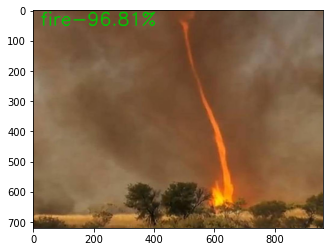

In [ ]:
import cv2
import time
clas = ["no fire","fire"]

path = "/content/drive/My Drive/DATASET/archive/test/1/100.jpg"

img = load_img(path,target_size=(224,224))
img1=cv2.imread(path)
img1 =cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
#re = cv2.imread(path)
#img =cv2.cvtColor(re,cv2.COLOR_BGR2RGB)
#img = cv2.resize(img,(224,224))
img = img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img,axis=0)
last = time.time()
pred = model.predict(img)
#print(time.time()-last)
op=clas[np.argmax(pred)]
e = np.argmax(pred)
x = round(pred[0][e]*100,2)
conf = str(x)+'%'
print(x)
print(op)

op = op + '-' + conf
if x>80.0:
    cv2.putText(img1,op,(25,50),cv2.FONT_HERSHEY_SIMPLEX,2,(0,200,0),3)
plt.imshow(img1)


In [ ]:
!pip install twilio